<a href="https://colab.research.google.com/github/gitclub-data/Agentic-AI/blob/master/Natual_language_Query_Answers_From_Database.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing all the nessary libraries

In [1]:
!pip install typing_extensions
!pip install langgraph
!pip install langchain-community
!pip install -U "langchain[google-genai]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 507.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.2/152.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 572.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 5.6 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-a

Connect With Google Drive

In [2]:
#connect colab with google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Create Real and Dummy Dataset Real for store real data to query, dummy store very much less but good quality data for validation purposes

In [3]:
# create a small database to store some data
import sqlite3
conn = sqlite3.connect('real_database.db')
dummy_conn = sqlite3.connect('dummy_database.db')

In [4]:
cursor = conn.cursor()
dummy_cursor = dummy_conn.cursor()

In [5]:
create_users_table = '''
    CREATE TABLE IF NOT EXISTS users (
        user_id INTEGER PRIMARY KEY,
        user_gender BOOLEAN,
        bucketized_user_age INTEGER,
        user_occupation_label INTEGER,
        user_occupation_text TEXT,
        user_zip_code INTEGER
    )
'''
cursor.execute(create_users_table)
dummy_cursor.execute(create_users_table)

In [6]:
create_ratings_table = '''
    CREATE TABLE IF NOT EXISTS ratings (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        movie_id INTEGER,
        user_id INTEGER,
        user_rating INTEGER,
        timestamp INTEGER
    )
'''
cursor.execute(create_ratings_table)
dummy_cursor.execute(create_ratings_table)

In [7]:
create_movies_table = '''
    CREATE TABLE IF NOT EXISTS movies (
        movie_id INTEGER PRIMARY KEY,
        movie_title TEXT,
        poster_url TEXT
    )
'''
cursor.execute(create_movies_table)
dummy_cursor.execute(create_movies_table)

MovieLens 1M with Posters & Metadata (Kaggle Dataset)

In [8]:
import pandas as pd

# Adjust paths if your files are in a subfolder
ratings_df = pd.read_csv('/content/drive/MyDrive/Movies_Data/ratings.csv')
movies_df = pd.read_csv('/content/drive/MyDrive/Movies_Data/movies.csv')
users_df = pd.read_csv('/content/drive/MyDrive/Movies_Data/users.csv')

ENTERED FULL DATA IN DUMMY DATABASE FOR NOW ONLY FOR POC PURPOSE

In [9]:
ratings_df.to_sql('ratings', conn, if_exists='append', index=False)
movies_df.to_sql('movies', conn, if_exists='append', index=False)
users_df.to_sql('users', conn, if_exists='append', index=False)

ratings_df.to_sql('ratings', dummy_conn, if_exists='append', index=False)
movies_df.to_sql('movies', dummy_conn, if_exists='append', index=False)
users_df.to_sql('users', dummy_conn, if_exists='append', index=False)

dummy_conn.commit()
dummy_conn.close()

conn.commit()
conn.close()

In [10]:
conn = sqlite3.connect('real_database.db')
cursor = conn.cursor()
cursor.execute('SELECT * FROM users')
rows = cursor.fetchall()

# Print each row
for row in rows:
    print(row)
    break
conn.commit()
conn.close()

(1, 0, 1, 17, 'K-12 student', 48067)


In [11]:
#initial table description

CREATED THIS JSON OF TABLE INFORMATION TO GET THE TABLE SCHEMA IN STRUCTURED FORMAT -> NEEDED AS INPUT SO THAT MODEL CAN EXCECTLY KNOW WHAT TYPE OF QUERY IT HAS TO GENERATE(Used Previously when not used embeddings..)

In [12]:
table_info = {
    "name": "tables_information",
    "tables": [
        {
            "table_name": "users",
            "table_description": "This table contains records of users who have watched the movie in the past.",
            "columns": [
                {
                    "column_name": "user_id",
                    "column_type": "INTEGER",
                    "column_description": "Unique identifier for each user"
                },
                {
                    "column_name": "user_gender",
                    "column_type": "BOOLEAN",
                    "column_description": "True = Male, False = Female"
                },
                {
                    "column_name": "bucketized_user_age",
                    "column_type": "INTEGER",
                    "column_description": (
                        "Age group bucket:\n"
                        "- 1: Under 18\n"
                        "- 18: 18–24\n"
                        "- 25: 25–34\n"
                        "- 35: 35–44\n"
                        "- 45: 45–49\n"
                        "- 50: 50–55\n"
                        "- 56: 56-.."
                    )
                },
                {
                    "column_name": "user_occupation_label",
                    "column_type": "INTEGER",
                    "column_description": (
                        "Integer code representing occupation:\n"
                        "- 0: other or not specified\n"
                        "- 1: academic/educator\n"
                        "- 2: artist\n"
                        "- 3: clerical/admin\n"
                        "- 4: college/grad student\n"
                        "- 5: customer service\n"
                        "- 6: doctor/health care\n"
                        "- 7: executive/managerial\n"
                        "- 8: farmer\n"
                        "- 9: homemaker\n"
                        "- 10: K-12 student\n"
                        "- 11: lawyer\n"
                        "- 12: programmer\n"
                        "- 13: retired\n"
                        "- 14: sales/marketing\n"
                        "- 15: scientist\n"
                        "- 16: self-employed\n"
                        "- 17: technician/engineer\n"
                        "- 18: tradesman/craftsman\n"
                        "- 19: unemployed\n"
                        "- 20: writer"
                    )
                },
                {
                    "column_name": "user_occupation_text",
                    "column_type": "TEXT",
                    "column_description": "Text description of the occupation (e.g. Writer)"
                },
                {
                    "column_name": "user_zip_code",
                    "column_type": "INTEGER",
                    "column_description": "ZIP code provided voluntarily by the user"
                }
            ]
        },
        {
            "table_name": "ratings",
            "table_description": "This table captures the ratings provided by users for specific movies.",
            "columns": [
                {
                    "column_name": "user_id",
                    "column_type": "INTEGER",
                    "column_description": "Foreign key referring to users table."
                },
                {
                    "column_name": "movie_id",
                    "column_type": "INTEGER",
                    "column_description": "Foreign key referring to movies table."
                },
                {
                    "column_name": "user_rating",
                    "column_type": "INTEGER",
                    "column_description": "Rating from 1 to 5 (whole stars only)."
                },
                {
                    "column_name": "timestamp",
                    "column_type": "INTEGER",
                    "column_description": "Unix timestamp when the rating was submitted."
                }
            ]
        },
        {
            "table_name": "movies",
            "table_description": "This table includes metadata related to the movies.",
            "columns": [
                {
                    "column_name": "movie_id",
                    "column_type": "INTEGER",
                    "column_description": "Unique movie identifier"
                },
                {
                    "column_name": "movie_title",
                    "column_type": "TEXT",
                    "column_description": "Title of the movie (with release year)"
                },
                {
                    "column_name": "poster_url",
                    "column_type": "TEXT",
                    "column_description": "Direct URL to the movie's poster image"
                }
            ]
        }
    ]
}

In [13]:
#plan of action: For getting table information from embeddings..

In [14]:
# use faiss vector store
# ->> type 1 -> table embedding stores whole table record (table and its column information in vector store).
#  (used for what table we will be needing for actually getting the data)
# ->> type 2 -> used to store the table name its column name and description of the column





# ->> getting the result by k nearest neighbour algo.. but it is impossible to determine if we got all the necessary details
# in the first try or may be we can find that out. so we let the model check if not find all the nessary details we are going
#  to search the table again untill reached the max limit and break out and sent can't find neccessary columns message to the output.

In [15]:
!pip install -qU langchain-community faiss-cpu sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.2/470.2 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.4 MB/s eta 0:00:00


Used a Open Source Model Because I do not have that much money to get a paid subscription

In [16]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [17]:
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

# Define embedding function that LangChain expects
embedding_function = lambda texts: model.encode(texts, convert_to_numpy=True)

# Create FAISS index
sample_embedding = model.encode("hello world")
embedding_dimension = len(sample_embedding)
index = faiss.IndexFlatL2(embedding_dimension)

# Create FAISS vector store
vector_store = FAISS(
    embedding_function=embedding_function,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Created Documents and saved them into vector store (column as well as tables)

In [18]:
#table schema
from langchain_core.documents import Document

user_schema = Document(
    page_content="""
Table Name: users
Description: This table contains records of users who have watched the movie in the past.

Columns:
- user_id (INTEGER): Unique identifier for each user
- user_gender (BOOLEAN): True = Male, False = Female
- bucketized_user_age (INTEGER): Age group bucket:
  - 1: Under 18
  - 18: 18–24
  - 25: 25–34
  - 35: 35–44
  - 45: 45–49
  - 50: 50–55
  - 56: 56 and above
- user_occupation_label (INTEGER): Integer code for occupation
  - 0: other or not specified
  - 1–20: specific occupations like artist, lawyer, student, etc.
- user_occupation_text (TEXT): Occupation description (e.g. Writer)
- user_zip_code (INTEGER): ZIP code provided voluntarily by the user
""",
    metadata={"source": "table_schema", "table_name": "users"}
)

ratings_schema = Document(
    page_content="""
Table Name: ratings
Description: This table captures the ratings provided by users for specific movies.

Columns:
- user_id (INTEGER): Foreign key referring to users table
- movie_id (INTEGER): Foreign key referring to movies table
- user_rating (INTEGER): Rating from 1 to 5 (whole stars only)
- timestamp (INTEGER): Unix timestamp when the rating was submitted
""",
    metadata={"source": "table_schema", "table_name": "ratings"}
)

movies_schema = Document(
    page_content="""
Table Name: movies
Description: This table includes metadata related to the movies.

Columns:
- movie_id (INTEGER): Unique movie identifier
- movie_title (TEXT): Title of the movie (with release year)
- poster_url (TEXT): Direct URL to the movie's poster image
""",
    metadata={"source": "table_schema", "table_name": "movies"}
)

In [19]:
user_id_doc = Document(
    page_content="- user_id (INTEGER): Unique identifier for each user",
    metadata={
        "source": "column_schema",
        "table_name": "users",
        "table_description": "This table contains records of users who have watched the movie in the past.",
        "column_name": "user_id"
    }
)

user_gender_doc = Document(
    page_content="- user_gender (BOOLEAN): True = Male, False = Female",
    metadata={
        "source": "column_schema",
        "table_name": "users",
        "table_description": "This table contains records of users who have watched the movie in the past.",
        "column_name": "user_gender"
    }
)

bucketized_user_age_doc = Document(
    page_content="""- bucketized_user_age (INTEGER): Age group bucket:
  - 1: Under 18
  - 18: 18–24
  - 25: 25–34
  - 35: 35–44
  - 45: 45–49
  - 50: 50–55
  - 56: 56 and above""",
    metadata={
        "source": "column_schema",
        "table_name": "users",
        "table_description": "This table contains records of users who have watched the movie in the past.",
        "column_name": "bucketized_user_age"
    }
)

user_occupation_label_doc = Document(
    page_content="""- user_occupation_label (INTEGER): Integer code for occupation
  - 0: other or not specified
  - 1–20: specific occupations like artist, lawyer, student, etc.""",
    metadata={
        "source": "column_schema",
        "table_name": "users",
        "table_description": "This table contains records of users who have watched the movie in the past.",
        "column_name": "user_occupation_label"
    }
)

user_occupation_text_doc = Document(
    page_content='- user_occupation_text (TEXT): Occupation description (e.g. Writer)',
    metadata={
        "source": "column_schema",
        "table_name": "users",
        "table_description": "This table contains records of users who have watched the movie in the past.",
        "column_name": "user_occupation_text"
    }
)

user_zip_code_doc = Document(
    page_content='- user_zip_code (INTEGER): ZIP code provided voluntarily by the user',
    metadata={
        "source": "column_schema",
        "table_name": "users",
        "table_description": "This table contains records of users who have watched the movie in the past.",
        "column_name": "user_zip_code"
    }
)

In [20]:
user_id__doc = Document(
    page_content="- user_id (INTEGER): Foreign key referring to users table",
    metadata={
        "source": "column_schema",
        "table_name": "ratings",
        "table_description": "This table captures the ratings provided by users for specific movies.",
        "column_name": "user_id"
    }
)

movie_id_doc = Document(
    page_content="- movie_id (INTEGER): Foreign key referring to movies table",
    metadata={
        "source": "column_schema",
        "table_name": "ratings",
        "table_description": "This table captures the ratings provided by users for specific movies.",
        "column_name": "movie_id"
    }
)

user_rating_doc = Document(
    page_content="- user_rating (INTEGER): Rating from 1 to 5 (whole stars only)",
    metadata={
        "source": "column_schema",
        "table_name": "ratings",
        "table_description": "This table captures the ratings provided by users for specific movies.",
        "column_name": "user_rating"
    }
)

timestamp_doc = Document(
    page_content="- timestamp (INTEGER): Unix timestamp when the rating was submitted",
    metadata={
        "source": "column_schema",
        "table_name": "ratings",
        "table_description": "This table captures the ratings provided by users for specific movies.",
        "column_name": "timestamp"
    }
)

In [21]:
movie_id__doc = Document(
    page_content="- movie_id (INTEGER): Unique movie identifier",
    metadata={
        "source": "column_schema",
        "table_name": "movies",
        "table_description": "This table includes metadata related to the movies.",
        "column_name": "movie_id"
    }
)

movie_title_doc = Document(
    page_content="- movie_title (TEXT): Title of the movie (with release year)",
    metadata={
        "source": "column_schema",
        "table_name": "movies",
        "table_description": "This table includes metadata related to the movies.",
        "column_name": "movie_title"
    }
)

poster_url_doc = Document(
    page_content="- poster_url (TEXT): Direct URL to the movie's poster image",
    metadata={
        "source": "column_schema",
        "table_name": "movies",
        "table_description": "This table includes metadata related to the movies.",
        "column_name": "poster_url"
    }
)

In [22]:
from langchain_core.documents import Document

MAX_TABLE_SCHEMA = 3
MAX_COLUMN_SCHEMA = 13

# Create Document objects (if not already)
raw_documents = [
    user_schema,
    ratings_schema,
    movies_schema,
    user_id__doc,
    user_gender_doc,
    bucketized_user_age_doc,
    user_occupation_label_doc,
    user_occupation_text_doc,
    user_zip_code_doc,
    user_id_doc,
    movie_id_doc,
    user_rating_doc,
    timestamp_doc,
    movie_id__doc,
    movie_title_doc,
    poster_url_doc
]

# Add documents to the FAISS vector store
vector_store.add_documents(raw_documents)

['eb7515de-8f32-4e98-babb-ad34f99c3dcb',
 '8f5eb222-1c55-4b37-acbc-4dffcb09f4d2',
 '27084202-9f72-4704-bde9-5dc94e579821',
 '21ef3b73-c06d-4df7-9f0c-ebaabe4b9359',
 '782bf032-0073-4e89-a41d-f6aaf96134e2',
 '701fcc6b-ce6e-4cfd-86a8-4c65d63623be',
 '3265883c-5796-48d3-ac26-4249c1f1ebb2',
 '50ba5b60-0a09-48db-8d72-b62acd6d4090',
 'ab5fbc01-83a6-402a-b031-72160bddf6e6',
 '74e6c4ed-3db0-4ee5-8df5-bdd4083c2fb0',
 'dc0e974a-887b-4207-b70c-65bcc5541cec',
 '2cc8ae6e-c455-4a29-81ef-5c917a0b78cd',
 'f396d71e-01e5-41f5-9f88-999d1f9ad163',
 '6970b2e4-7802-4a5c-92f3-57c2f16f75cc',
 '2eb1ffa9-1d26-4829-93e5-091deb5293ff',
 'adcb42a8-b646-4bb3-a5c7-6aaba133cd57']

In [23]:
vector_store.save_local("table_information")

Used a free tier model and you know what I needed my keys safe so i have stored in secrets 'key icon ON YOUR LEFT (for marvel-fans only)' (In colab)

In [24]:
import os
from langchain.chat_models import init_chat_model
from google.colab import userdata

os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')
llm = init_chat_model("google_genai:gemini-2.0-flash")

Started Creating Our First Workflow (Related Table generation)

In [25]:
from typing_extensions import Annotated
from typing_extensions import TypedDict
from langgraph.graph import START,END, StateGraph
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser

class TableState(TypedDict):
    question: str # user query
    relevant_tables : int  # no of relevant tables
    table_documents : list # tables documents which are going to fetch
    validation_result : dict # validation result
    resultant_tables: list # list of tables
    error_result : str # if the relevant tables can not found.
    vectorstore : FAISS

def get_relevant_tables(state : TableState):
  vector_store = state["vectorstore"]
  results = vector_store.similarity_search(
    state["question"],
    k=state["relevant_tables"],
    filter={"source": "table_schema"},
  )
  return {"table_documents":results}

In [26]:
class QueryJsonOutput(TypedDict):
    """Generated SQL query."""
    enough_information: Annotated[bool, ..., "whether the available schema provides sufficient information to write a valid SQL query that could answer the question or not."]

In [27]:
def validate_relevant_tables(state : TableState):
  system_prompt = """
You are a helpful assistant that evaluates whether a given set of database tables contains enough schema information to generate a valid SQL query that answers a natural language question **in full**.

You will be provided with:
- A natural language question.
- One or more database tables. Each table includes:
  - Table name and description
  - Column names, data types, and column descriptions

Assume that:
- All columns are populated with valid and correctly typed data.
- You are not required to write the SQL query or answer the question — only to determine whether it is possible to generate a complete query using the schema provided.

Your task is to:
1. Carefully analyze the natural language question to identify **all distinct information requirements** (e.g., filters, metrics, grouping, sorting).
2. Review the table schemas and ensure that **every required data point** is represented by one or more columns in the schema.
3. Consider relationships between tables only if they are explicitly defined or logically inferable from naming or descriptions.

Only if **every part** of the question can be addressed with the schema provided, return:
{{"enough_information": true}}

If **any required element is missing** (e.g., age of users, movie ratings, like counts, timestamps, etc.), return:
{{"enough_information": false}}

Constraints:
- You must evaluate the entire question in detail — partial answerability is not sufficient.
- Do not assume access to external data, hidden metadata, or business logic beyond the schema.
- Do not write or return SQL queries.
- Your output must be only a single JSON object.

Input format:
Question: {natural_language_question}

Table(s):
{table_name_and_description}

Example output:
{{"enough_information": true}}
"""

  table_information = ""
  for documents in state["table_documents"]:
    table_information += "\n"+documents.page_content

  print(table_information)

  prompt = ChatPromptTemplate.from_template(system_prompt)

  structured_llm = llm.with_structured_output(QueryJsonOutput)

  validation_chain = prompt | structured_llm

  result = validation_chain.invoke({"natural_language_question" : state["question"], "table_name_and_description": table_information})

  print(result)
  return {"validation_result" : result}

In [28]:
def send_tables(state:TableState):
  tables = set()
  for document in state["table_documents"]:
    tables.add(document.metadata["table_name"])
  return {"resultant_tables" : list(tables)}

def not_possible_answer(state: TableState):
  return {"error_result":"result can not be found because It looks like you do not have enough data"}

In [29]:
def transition_by_validation(state: TableState):
  if "enough_information" not in state["validation_result"]:
    raise Exception("llm is not returning correct json")
  if state["validation_result"]["enough_information"] is True:
    return "answer_found"
  else:
    if state["relevant_tables"]<MAX_TABLE_SCHEMA:
      return "increase_relevence and reiletrate"
    else:
      return "answer_can_not_found"

In [30]:
def increase_relevance(state: TableState):
  result = state["relevant_tables"] + 2
  return {"relevant_tables" : result}

In [31]:
# step 1 -> send the question
# step 2 -> get the resultant tables.. with default nearest value as 2
# step 3 -> validate if the resultant tables are enough
# step 4 -> if not increase the nearest neighbour by 2 and get the data and validate it again

# step 5 -> get the column data with the default nearest neighbour value as 3
# step 6 -> validate the resulttant


table_graph_builder = StateGraph(TableState)
# graph_builder = StateGraph(State)

table_graph_builder.add_node("get_relevant_tables", get_relevant_tables)
table_graph_builder.add_node("validate_tables", validate_relevant_tables)
table_graph_builder.add_node("send_tables", send_tables)
table_graph_builder.add_node("not_possible_answer", not_possible_answer)
table_graph_builder.add_node("increase_relevance", increase_relevance)

table_graph_builder.add_edge(START, "get_relevant_tables")
table_graph_builder.add_edge("get_relevant_tables", "validate_tables")
table_graph_builder.add_conditional_edges("validate_tables", transition_by_validation, {"increase_relevence and reiletrate" : "increase_relevance", "answer_found" : "send_tables", "answer_can_not_found": "not_possible_answer"})
table_graph_builder.add_edge("increase_relevance", "get_relevant_tables")
table_graph_builder.add_edge("send_tables", END)
table_graph_builder.add_edge("not_possible_answer", END)

table_gen_agent = table_graph_builder.compile()


# 1 - get back and get more similar results
# 2 - output the result
# 3 - getting output is not possible

# graph_builder.add_node("write_query", write_query)
# graph_builder.add_node("validate_query", validate_query)
# graph_builder.add_node("execute_query", execute_query)
# graph_builder.add_node("generate_answer", generate_answer)

# graph_builder.add_edge(START, "write_query")
# graph_builder.add_edge("write_query", "validate_query")

# graph_builder.add_conditional_edges(
#     "validate_query",
#     transition_by_error,
#     {"valid_query":"execute_query",
#      "not_valid_query":"write_query"}
# )

# graph_builder.add_edge("execute_query", "generate_answer")
# graph_builder.add_edge("generate_answer", END)

# graph = graph_builder.compile()
# sql_agent

In [32]:
from IPython.display import Image, display
display(Image("_table_gen_agent_graph.png"))

FileNotFoundError: No such file or directory: '_table_gen_agent_graph.png'

FileNotFoundError: No such file or directory: '_table_gen_agent_graph.png'

<IPython.core.display.Image object>

In [33]:
for step in table_gen_agent.stream(
    {"question": "tell me 5 most likeable movies by our young users?", "relevant_tables": 1, "vectorstore": vector_store}, stream_mode="updates"
):
    print(step)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'get_relevant_tables': {'table_documents': [Document(id='8f5eb222-1c55-4b37-acbc-4dffcb09f4d2', metadata={'source': 'table_schema', 'table_name': 'ratings'}, page_content='\nTable Name: ratings\nDescription: This table captures the ratings provided by users for specific movies.\n\nColumns:\n- user_id (INTEGER): Foreign key referring to users table\n- movie_id (INTEGER): Foreign key referring to movies table\n- user_rating (INTEGER): Rating from 1 to 5 (whole stars only)\n- timestamp (INTEGER): Unix timestamp when the rating was submitted\n')]}}


Table Name: ratings
Description: This table captures the ratings provided by users for specific movies.

Columns:
- user_id (INTEGER): Foreign key referring to users table
- movie_id (INTEGER): Foreign key referring to movies table
- user_rating (INTEGER): Rating from 1 to 5 (whole stars only)
- timestamp (INTEGER): Unix timestamp when the rating was submitted

{'enough_information': False}
{'validate_tables': {'validation_result': {'enough_i

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'enough_information': True}
{'validate_tables': {'validation_result': {'enough_information': True}}}
{'send_tables': {'resultant_tables': ['ratings', 'users', 'movies']}}


Table Generation Workflow is done and the output is amazing I am getting all the related tables.. as you can see in resultant_tables

Started Working on Related Column Generation Workflow

In [34]:
class ColumnState(TypedDict):
    question : str # user query
    relevant_columns : int  # no of relevant columns
    column_documents : list # columns documents which are going to fetch
    validation_result : dict # validation result
    input_tables : list # list of columns to get the documents
    result : str # final output
    error_result : str # if the relevant tables can not found.
    vectorstore : FAISS

In [35]:
def get_relevant_columns(state: ColumnState):
  vector_store = state["vectorstore"]
  res = vector_store.similarity_search(
    state["question"],
    k=state["relevant_columns"],
    filter={"source": "column_schema", "table_name": {"$in": state["input_tables"]}},
  )

  return {"column_documents": res}

In [36]:
def validate_relevant_tables_and_columns(state : ColumnState):
  system_prompt = """
You are a helpful assistant that evaluates whether a given set of database tables contains enough schema information to generate a valid SQL query that answers a natural language question **in full**.

You will be provided with:
- A natural language question.
- One or more database tables. Each table includes:
  - Table name and description
  - Column names, data types, and column descriptions

Assume that:
- All columns are populated with valid and correctly typed data.
- You are not required to write the SQL query or answer the question — only to determine whether it is possible to generate a complete query using the schema provided.

Your task is to:
1. Carefully analyze the natural language question to identify **all distinct information requirements** (e.g., filters, metrics, grouping, sorting).
2. Review the table schemas and ensure that **every required data point** is represented by one or more columns in the schema.
3. Consider relationships between tables only if they are explicitly defined or logically inferable from naming or descriptions.

Only if **every part** of the question can be addressed with the schema provided, return:
{{"enough_information": true}}

If **any required element is missing** (e.g., age of users, movie ratings, like counts, timestamps, etc.), return:
{{"enough_information": false}}

Constraints:
- You must evaluate the entire question in detail — partial answerability is not sufficient.
- Do not assume access to external data, hidden metadata, or business logic beyond the schema.
- Do not write or return SQL queries.
- Your output must be only a single JSON object.

Input format:
Question: {natural_language_question}

Table(s):
{table_name_and_description}

Example output:
{{"enough_information": true}}
"""


  column_documents = state["column_documents"]

  table_column_documents = {}
  for documents in column_documents:
    if documents.metadata["table_name"] not in table_column_documents:
      table_column_documents[documents.metadata["table_name"]] = "Table Name: "+documents.metadata["table_name"]+"\n"
      table_column_documents[documents.metadata["table_name"]] += "Description: "+documents.metadata["table_description"]
      table_column_documents[documents.metadata["table_name"]] += "\n\n"
      table_column_documents[documents.metadata["table_name"]] += "Columns:\n"
    table_column_documents[documents.metadata["table_name"]] += documents.page_content

  table_column_information = ""
  for tables in table_column_documents:
    table_column_information += "\n"+table_column_documents[tables]

  print(table_column_information)

  prompt = ChatPromptTemplate.from_template(system_prompt)

  structured_llm = llm.with_structured_output(QueryJsonOutput)

  validation_chain = prompt | structured_llm

  result = validation_chain.invoke({"natural_language_question" : state["question"], "table_name_and_description": table_column_information})

  return {"validation_result" : result}

In [37]:
def transition_by_column_validation(state: ColumnState):
  if "enough_information" not in state["validation_result"]:
    raise Exception("llm is not returning correct json")
  if state["validation_result"]["enough_information"] is True:
    return "answer_found"
  else:
    if state["relevant_columns"]<MAX_COLUMN_SCHEMA:
      return "increase_relevence and reiletrate"
    else:
      return "answer_can_not_found"

In [38]:
def increase_column_relevance(state: ColumnState):
  result = state["relevant_columns"] + 2
  return {"relevant_columns" : result}

def send_tables_information_as_string(state : ColumnState):
  column_documents = state["column_documents"]

  table_column_documents = {}
  for documents in column_documents:
    if documents.metadata["table_name"] not in table_column_documents:
      table_column_documents[documents.metadata["table_name"]] = "Table Name: "+documents.metadata["table_name"]+"\n"
      table_column_documents[documents.metadata["table_name"]] += "Description: "+documents.metadata["table_description"]
      table_column_documents[documents.metadata["table_name"]] += "\n\n"
      table_column_documents[documents.metadata["table_name"]] += "Columns:\n"
    table_column_documents[documents.metadata["table_name"]] += documents.page_content

  table_column_information = ""
  for tables in table_column_documents:
    table_column_information += "\n"+table_column_documents[tables]

  return {"result": table_column_information}

In [39]:
graph_builder = StateGraph(ColumnState)
graph_builder.add_node("get_relevant_columns", get_relevant_columns)
graph_builder.add_node("validate_relevant_tables_and_columns", validate_relevant_tables_and_columns)
graph_builder.add_node("increase_relevance", increase_column_relevance)
graph_builder.add_node("send_tables_information_as_string", send_tables_information_as_string)
graph_builder.add_node("not_possible_answer", not_possible_answer)

graph_builder.add_edge(START, "get_relevant_columns")
graph_builder.add_edge("get_relevant_columns", "validate_relevant_tables_and_columns")
graph_builder.add_conditional_edges("validate_relevant_tables_and_columns", transition_by_column_validation, {"increase_relevence and reiletrate" : "increase_relevance", "answer_found" : "send_tables_information_as_string", "answer_can_not_found": "not_possible_answer"})
graph_builder.add_edge("increase_relevance", "get_relevant_columns")
graph_builder.add_edge("send_tables_information_as_string", END)
graph_builder.add_edge("not_possible_answer", END)


column_gen_agent = graph_builder.compile()

In [40]:
from IPython.display import Image, display
display(Image("_column_gen_agent_graph.png"))

FileNotFoundError: No such file or directory: '_column_gen_agent_graph.png'

FileNotFoundError: No such file or directory: '_column_gen_agent_graph.png'

<IPython.core.display.Image object>

In [41]:
for step in column_gen_agent.stream(
    {"question": "top 5 ranked movies?", "relevant_columns": 4, "input_tables" : ['ratings', 'movies'], "vectorstore": vector_store}, stream_mode="updates"
):
    print(step)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'get_relevant_columns': {'column_documents': [Document(id='6970b2e4-7802-4a5c-92f3-57c2f16f75cc', metadata={'source': 'column_schema', 'table_name': 'movies', 'table_description': 'This table includes metadata related to the movies.', 'column_name': 'movie_id'}, page_content='- movie_id (INTEGER): Unique movie identifier'), Document(id='2cc8ae6e-c455-4a29-81ef-5c917a0b78cd', metadata={'source': 'column_schema', 'table_name': 'ratings', 'table_description': 'This table captures the ratings provided by users for specific movies.', 'column_name': 'user_rating'}, page_content='- user_rating (INTEGER): Rating from 1 to 5 (whole stars only)'), Document(id='dc0e974a-887b-4207-b70c-65bcc5541cec', metadata={'source': 'column_schema', 'table_name': 'ratings', 'table_description': 'This table captures the ratings provided by users for specific movies.', 'column_name': 'movie_id'}, page_content='- movie_id (INTEGER): Foreign key referring to movies table'), Document(id='2eb1ffa9-1d26-4829-93e5-09

Can get the output in any fomat but chosen simple string as our next workflow will be needing the output in the simple plain text

In [42]:
#plan of action: For getting answers from a query

In [43]:
# user query ask ->

# Node-1 -> Query generation Agent -> take the llm , table description and prompt and generate a sqlite query
# Node-2 -> Validate the query -> run the query in sqlite and checks if it gives any error or not if yes return the error and move for refinement
# if no move to llm to generate the output
# Node-3 -> Refine the query -> take the error , table description and prompt and do the query generation again and move back to agent-2

# After getting the output
# Node-4 -> Geneate the final output and return it using a table.


Creation of an Sql Agent Begins -> query generator validator and executor

In [44]:
from typing_extensions import Annotated
from typing_extensions import TypedDict

class Error(TypedDict):
    iserror : bool
    error : str

class SqlState(TypedDict):
    question: str
    query: str
    result: str
    answer: str
    top_k: int
    table_schema : str
    dialect : str
    error : Error

class QueryOutput(TypedDict):
    """Generated SQL query."""
    query: Annotated[str, ..., "Syntactically valid SQL query."]

def write_query(state: SqlState):
    """Generate SQL query to fetch information."""
    if 'error' in state and 'iserror' in state['error'] and state['error']['iserror']:

      system_error_prompt = """
          You are an expert SQL query assistant. Your task is to analyze a provided SQL query, along with a natural language question, error description, and table schema (with column information). You must identify issues in the SQL query and generate a corrected, syntactically valid SQL query that fulfills the user’s intent based on the given SQL dialect. Follow these strict instructions:

          What You Receive as Input:
          - A natural language question representing the user's intent.
          - A raw SQL query generated for that question.
          - An error message (if any) generated during execution of the query.
          - A schema, which includes table names and the list of valid columns for each table.
          - The required SQL dialect (e.g., PostgreSQL, MySQL, SQLite, etc.).
          - (Optional) A number of examples the user wants in the result.

          What You Must Do:
          1. Understand the Intent:
            - Parse the natural language question to determine the user’s actual intent and what data they are trying to retrieve.

          2. Validate the Original Query:
            - Compare the SQL query against the schema.
            - Identify misuse of columns, incorrect table joins, or syntax errors.
            - Use the provided error message to help locate the issue (e.g., missing columns, ambiguous names, invalid syntax, unsupported features).

          3. Correct the Query:
            - Rewrite the SQL query to fix any issues while preserving the user’s intent.
            - Ensure the query is syntactically correct for the specified SQL dialect.

          4. Apply Output Constraints:
            - Only use columns and tables explicitly defined in the schema. Do not use any undefined columns.
            - Be aware of which columns belong to which tables to avoid ambiguous or invalid references.
            - If the user specifies a number of examples (top K results), apply an appropriate LIMIT K clause.
            - Sort the results using meaningful columns (e.g., created_at, score, or other relevance indicators) to provide the most informative and relevant answers.
            - Ensure the query is well-structured and readable.

          Rules to Follow:
          - Always use only the columns listed in the schema.
          - Be aware of which columns belong to which tables to avoid invalid references.
          - Choose sorting columns that provide semantic value or align with the user's question.
          - Follow the syntax and functions specific to the provided SQL dialect.
          - If LIMIT is not specified and no number of examples is given, default to LIMIT 10.
          - Use fully qualified column names (table.column) where needed for clarity and correctness.

          Output Format:
          Your response should include only the final corrected SQL query, formatted properly. Do not include explanations or extra text unless specifically asked for.
      """

      user_prompt = """Input Information:
          - Natural language question: {question}
          - Original SQL query: {original_query}
          - Error message (if any): {error_message}
          - SQL dialect: {dialect}
          - Number of examples requested (if any): {k_examples}
          - Schema (tables and columns): {schema}
      """

      error_prompt_template = ChatPromptTemplate(
          [("system", system_error_prompt), ("user", user_prompt)]
      )

      prompt = error_prompt_template.invoke(
          {
              "error_message" : state['error']['error'],
              "original_query" : state['query'],
              "dialect": state["dialect"],
              "k_examples": str(state["top_k"]),
              "schema": state["table_schema"],
              "question": state["question"],
          }
      )

    else:

      system_message = """
        Given an input question, create a syntactically correct {dialect} query to
        run to help find the answer. Unless the user specifies in his question a
        specific number of examples they wish to obtain, ensure the query limits the output to
        no more than {top_k} entries. You can order the results by a relevant column to
        return the most interesting examples in the database.

        Never query for all the columns from a specific table, only ask for a the
        few relevant columns given the question.

        Pay attention to use only the column names that you can see in the schema
        description. Be careful to not query for columns that do not exist. Also,
        pay attention to which column is in which table.

        Only use the following tables:
        {table_info}
      """

      user_prompt = "Question: {input}"

      query_prompt_template = ChatPromptTemplate(
          [("system", system_message), ("user", user_prompt)]
      )

      prompt = query_prompt_template.invoke(
          {
              "dialect": state["dialect"],
              "top_k": str(state["top_k"]),
              "table_info": state["table_schema"],
              "input": state["question"],
          }
      )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

In [45]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool

def execute_query(state: SqlState):
    """Execute SQL query."""
    conn = sqlite3.connect('real_database.db')
    cursor = conn.cursor()
    cursor.execute(state["query"])
    rows = cursor.fetchall()
    conn.commit()
    conn.close()
    return {"result": rows}

    # execute_query_tool = QuerySQLDatabaseTool(db=db)
    # return {"result": execute_query_tool.invoke(state["query"])}

In [46]:
def validate_query(state: SqlState):
  """Validate Sql Query"""
  conn = sqlite3.connect('dummy_database.db')
  cursor = conn.cursor()
  try:
    cursor.execute(state["query"])
    rows = cursor.fetchall()
    return {"error" : {"iserror": False, "error": ''}}
  except Exception as e:
    return {"error" : {"iserror": True, "error": str(e)}}
  finally:
    cursor.close()
    conn.close()

In [47]:
execute_query({"query": "SELECT count(DISTINCT movie_id) FROM ratings LIMIT 10"})

{'result': [(3706,)]}

In [48]:
def generate_answer(state: SqlState):
    """Answer question using retrieved information as context."""
    prompt = (
        "You are a data interpretation assistant.\n\n"
        "Answer the user's question clearly and directly using only the provided data.\n\n"
        "If you cannot find the answer from the provided data, simply state:\n"
        "\"I cannot provide the answer using the provided data.\"\n"
        "Do not give any explanation or reasoning.\n\n"
        "If you can find the answer, do not mention SQL queries or SQL results in your response. Instead, provide:\n"
        "- A clear, final answer that directly addresses the user's question.\n"
        "- A brief explanation of how the answer was derived, including what in the data supports it (but not the query used).\n\n"
        "Keep your response focused, factual, and based solely on the provided information."
        f"Question: {state['question']}\n"
        f"SQL Query: {state['query']}\n"
        f"SQL Result: {state['result']}"
    )
    print("query : ", state['query'])
    print("result : ", state['result'])
    response = llm.invoke(prompt)
    return {"answer": response.content}

In [49]:
def transition_by_error(state: SqlState):
  if state["error"]["iserror"] is True:
    return "not_valid_query"
  else:
    return "valid_query"

In [50]:
from langgraph.graph import START,END, StateGraph


sql_graph_builder = StateGraph(SqlState)

sql_graph_builder.add_node("write_query", write_query)
sql_graph_builder.add_node("validate_query", validate_query)
sql_graph_builder.add_node("execute_query", execute_query)
sql_graph_builder.add_node("generate_answer", generate_answer)

sql_graph_builder.add_edge(START, "write_query")
sql_graph_builder.add_edge("write_query", "validate_query")

sql_graph_builder.add_conditional_edges(
    "validate_query",
    transition_by_error,
    {"valid_query":"execute_query",
     "not_valid_query":"write_query"}
)

sql_graph_builder.add_edge("execute_query", "generate_answer")
sql_graph_builder.add_edge("generate_answer", END)

sql_agent = sql_graph_builder.compile()
# sql_agent

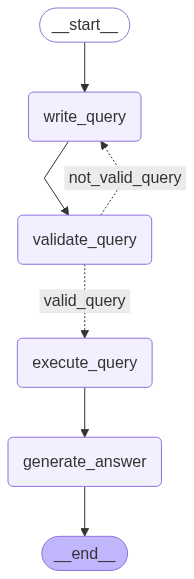

In [51]:
from IPython.display import Image, display

display(Image(sql_agent.get_graph().draw_mermaid_png()))

In [52]:
def get_dialect():
  conn = sqlite3.connect(":memory:")
  # Create a cursor to interact with the database
  cursor = conn.cursor()
  # Get the SQLite version
  cursor.execute("select sqlite_version();")
  version = cursor.fetchone()[0]
  return 'sqlite : '+version

In [53]:
sc = '\nTable Name: movies\nDescription: This table includes metadata related to the movies.\n\nColumns:\n- movie_id (INTEGER): Unique movie identifier- movie_title (TEXT): Title of the movie (with release year)\nTable Name: ratings\nDescription: This table captures the ratings provided by users for specific movies.\n\nColumns:\n- user_rating (INTEGER): Rating from 1 to 5 (whole stars only)- movie_id (INTEGER): Foreign key referring to movies table'
for step in sql_agent.stream(
    {"question": "top 5 ranked movies?","dialect":get_dialect(),"top_k":5,"table_schema":sc}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT movie_title FROM movies JOIN ratings ON movies.movie_id = ratings.movie_id ORDER BY user_rating DESC LIMIT 5'}}
{'validate_query': {'error': {'iserror': False, 'error': ''}}}
{'execute_query': {'result': [('Backdraft (1991)',), ('Jaws 3-D (1983)',), ('Key Largo (1948)',), ('Natural Born Killers (1994)',), ('Princess Bride, The (1987)',)]}}
query :  SELECT movie_title FROM movies JOIN ratings ON movies.movie_id = ratings.movie_id ORDER BY user_rating DESC LIMIT 5
result :  [('Backdraft (1991)',), ('Jaws 3-D (1983)',), ('Key Largo (1948)',), ('Natural Born Killers (1994)',), ('Princess Bride, The (1987)',)]
{'generate_answer': {'answer': 'The top 5 ranked movies are: Backdraft (1991), Jaws 3-D (1983), Key Largo (1948), Natural Born Killers (1994), and Princess Bride, The (1987). This is based on ordering the movies by their user ratings in descending order and selecting the top 5.'}}


In [54]:
# for step in sql_agent.stream(
#     {"question": "Backdraft released in?","dialect":get_dialect(),"top_k":5,"table_schema":sc}, stream_mode="updates"
# ):
#     print(step)

In [55]:
# for step in sql_agent.stream(
#     {"question": "how many users are unsatisfied with the movies?","dialect":get_dialect(),"top_k":5,"table_schema":sc}, stream_mode="updates"
# ):
#     print(step)

In [56]:
# for step in sql_agent.stream(
#     {"question": "how many users are satisfied with the movies?","dialect":get_dialect(),"top_k":5,"table_schema":sc}, stream_mode="updates"
# ):
#     print(step)

In [57]:
# for step in sql_agent.stream(
#     {"question": "tell me 5 most likeable movies by our old users?","dialect":get_dialect(),"top_k":5,"table_schema":sc}, stream_mode="updates"
# ):
#     print(step)

In [58]:
# for step in sql_agent.stream(
#     {"question": "tell me 5 most likeable movies by our young users?","dialect":get_dialect(),"top_k":5,"table_schema":sc}, stream_mode="updates"
# ):
#     print(step)

In [59]:
# for step in sql_agent.stream(
#     {"question": "tell me 5 most likeable movies by our mid age users?","dialect":get_dialect(),"top_k":5,"table_schema":sc}, stream_mode="updates"
# ):
#     print(step)

In [60]:
# for step in sql_agent.stream(
#     {"question": "top 5 ranked movies?","dialect":get_dialect(),"top_k":5,"table_schema":sc}, stream_mode="updates"
# ):
#     print(step)

In [61]:
# res = sql_agent.invoke(
#     {"question": "top 5 ranked movies?","dialect":get_dialect(),"top_k":5,"table_schema":sc}
# )


Combined them together to create a multi-agentic workflow

In [62]:
class State(TypedDict):
    question : str # user query
    fetched_tables : list
    table_information : str
    init_relevant_tables: int
    init_relevant_columns : int
    vectorstore: FAISS
    relevant_columns : list
    dialect: str
    top_k : int
    sql_agent_output : str
    final_output : str
    error : str
    iserror : bool

In [63]:
def invoke_get_table_agaent(state : State):
  print("passed_values", {"question": state["question"], "relevant_tables": state["init_relevant_tables"], "vectorstore": state["vectorstore"]})
  res = table_gen_agent.invoke({"question": state["question"], "relevant_tables": state["init_relevant_tables"], "vectorstore": state["vectorstore"]})
  if 'error_result' in res:
    return {'error' : res['error_result'], 'iserror' : True}
  final_result = res['resultant_tables']
  return {'fetched_tables' : final_result}

In [64]:
def invoke_get_column_agent(state: State):
  print({"question": state["question"], "relevant_columns": state["init_relevant_columns"],"input_tables" : state["fetched_tables"], "vectorstore": state["vectorstore"]})
  res = column_gen_agent.invoke({"question": state["question"], "relevant_columns": state["init_relevant_columns"],"input_tables" : state["fetched_tables"], "vectorstore": state["vectorstore"]})
  if 'error_result' in res:
    return {'error' : res['error_result'], 'iserror' : True}
  final_result = res['result']
  return {'table_information' : final_result}

In [65]:
def get_final_output(state: State):
  res = sql_agent.invoke({"question": state["question"],"dialect": state["dialect"], "top_k":state["top_k"], "table_schema": state["table_information"]})
  final_result = res['answer']
  return {'sql_agent_output': final_result}

In [66]:
def generate_final_answer(state: State):
  if "iserror" in state and state["iserror"]:
    return {'final_output' : state['error']}
  else:
    return {'final_output' : state['sql_agent_output']}

In [67]:
def transition_state(state: State):
  if "iserror" in state and state["iserror"]:
    return "generate_output"
  else:
    return "next_step"

In [68]:
combined_agent_builder = StateGraph(State)

combined_agent_builder.add_node("table_agent", invoke_get_table_agaent)
combined_agent_builder.add_node("column_agent", invoke_get_column_agent)
combined_agent_builder.add_node("sql_agent", get_final_output)
combined_agent_builder.add_node("generate_final_answer", generate_final_answer)

combined_agent_builder.add_edge(START, "table_agent")
combined_agent_builder.add_conditional_edges(
    "table_agent",
    transition_state,
    {"generate_output":"generate_final_answer",
     "next_step":"column_agent"}
)
combined_agent_builder.add_conditional_edges(
    "column_agent",
    transition_state,
    {"generate_output":"generate_final_answer",
     "next_step":"sql_agent"}
)
combined_agent_builder.add_edge("sql_agent", "generate_final_answer")
combined_agent_builder.add_edge("generate_final_answer", END)

combined_agent = combined_agent_builder.compile()

In [69]:
from IPython.display import Image, display
display(Image("_table_gen_agent_graph.png"))

FileNotFoundError: No such file or directory: '_table_gen_agent_graph.png'

FileNotFoundError: No such file or directory: '_table_gen_agent_graph.png'

<IPython.core.display.Image object>

In [70]:
from IPython.display import Image, display
display(Image("_column_gen_agent_graph.png"))

FileNotFoundError: No such file or directory: '_column_gen_agent_graph.png'

FileNotFoundError: No such file or directory: '_column_gen_agent_graph.png'

<IPython.core.display.Image object>

In [71]:
from IPython.display import Image, display
display(Image("_sql_agent_graph.png"))

FileNotFoundError: No such file or directory: '_sql_agent_graph.png'

FileNotFoundError: No such file or directory: '_sql_agent_graph.png'

<IPython.core.display.Image object>

In [72]:
from IPython.display import Image, display
display(Image("_combined_agent_graph.png"))

FileNotFoundError: No such file or directory: '_combined_agent_graph.png'

FileNotFoundError: No such file or directory: '_combined_agent_graph.png'

<IPython.core.display.Image object>

In [73]:
# for step in table_gen_agent.stream(
#     {'question': 'top 5 ranked movies?', 'relevant_tables': 1, 'vectorstore': vector_store}, stream_mode="updates"
# ):
#     print(step)

In [74]:
# for step in column_gen_agent.stream({"question": "top 5 ranked movies??", "relevant_columns": 1, "input_tables" : ['users', 'ratings', 'movies'], "vectorstore": vector_store}, stream_mode="updates"):
# column_gen_agent.invoke({"question": "top 5 ranked movies?", "relevant_columns": 2, "input_tables" : ['users', 'ratings', 'movies'], "vectorstore": vector_store})
    # print(step)

In [75]:
# column_gen_agent.invoke({"question": "top 5 ranked movies?", "relevant_columns": 3, "input_tables" : ['users', 'ratings', 'movies'], "vectorstore": vector_store})


In [76]:
combined_agent.invoke({"question": "Backdraft released in?", "dialect":get_dialect(), "top_k":5, "vectorstore":vector_store, "init_relevant_tables": 2, "init_relevant_columns": 4})

passed_values {'question': 'Backdraft released in?', 'relevant_tables': 2, 'vectorstore': <langchain_community.vectorstores.faiss.FAISS object at 0x787afd303290>}


Table Name: movies
Description: This table includes metadata related to the movies.

Columns:
- movie_id (INTEGER): Unique movie identifier
- movie_title (TEXT): Title of the movie (with release year)
- poster_url (TEXT): Direct URL to the movie's poster image


Table Name: ratings
Description: This table captures the ratings provided by users for specific movies.

Columns:
- user_id (INTEGER): Foreign key referring to users table
- movie_id (INTEGER): Foreign key referring to movies table
- user_rating (INTEGER): Rating from 1 to 5 (whole stars only)
- timestamp (INTEGER): Unix timestamp when the rating was submitted



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'enough_information': True}
{'question': 'Backdraft released in?', 'relevant_columns': 4, 'input_tables': ['ratings', 'movies'], 'vectorstore': <langchain_community.vectorstores.faiss.FAISS object at 0x787afd303290>}

Table Name: movies
Description: This table includes metadata related to the movies.

Columns:
- movie_title (TEXT): Title of the movie (with release year)- poster_url (TEXT): Direct URL to the movie's poster image- movie_id (INTEGER): Unique movie identifier
Table Name: ratings
Description: This table captures the ratings provided by users for specific movies.

Columns:
- movie_id (INTEGER): Foreign key referring to movies table


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


query :  SELECT movie_title FROM movies WHERE movie_title LIKE "Backdraft (%)" LIMIT 5
result :  [('Backdraft (1991)',)]


{'question': 'Backdraft released in?',
 'fetched_tables': ['ratings', 'movies'],
 'table_information': "\nTable Name: movies\nDescription: This table includes metadata related to the movies.\n\nColumns:\n- movie_title (TEXT): Title of the movie (with release year)- poster_url (TEXT): Direct URL to the movie's poster image- movie_id (INTEGER): Unique movie identifier\nTable Name: ratings\nDescription: This table captures the ratings provided by users for specific movies.\n\nColumns:\n- movie_id (INTEGER): Foreign key referring to movies table",
 'init_relevant_tables': 2,
 'init_relevant_columns': 4,
 'vectorstore': <langchain_community.vectorstores.faiss.FAISS at 0x787afd303290>,
 'dialect': 'sqlite : 3.37.2',
 'top_k': 5,
 'sql_agent_output': 'Backdraft was released in 1991. The movie title "Backdraft (1991)" was found in the data.',
 'final_output': 'Backdraft was released in 1991. The movie title "Backdraft (1991)" was found in the data.'}